In [50]:
%matplotlib inline
import momi		## momi2 analysis
import logging		## create log file

logging.basicConfig(level=logging.INFO,
                    filename="momi_agl_log.txt")

In [51]:
sfs = momi.Sfs.load("agl-hom_comb_SNPs_phased-filtered-50per.sfs.gz")
print("Avg pairwise heterozygosity", sfs.avg_pairwise_hets[:5])
print("populations", sfs.populations)
print("percent missing data per population", sfs.p_missing)

Avg pairwise heterozygosity [[0.87995169 0.57142857 0.33333333]
 [0.72183794 0.57142857 0.        ]
 [0.51897861 0.25       0.        ]
 [0.25362319 0.53571429 0.18518519]
 [0.9770751  0.         0.        ]]
populations ('P_ag', 'P_agA', 'P_ho')
percent missing data per population [0.19339623 0.1509434  0.23396226]


In [106]:
#test. pure isolation model, not estimating any parameters. Not used in paper.
no_migration_model = momi.DemographicModel(N_e=1e5, gen_time=1.7, muts_per_gen = 5e-10)

no_migration_model.set_data(sfs)

no_migration_model.add_leaf("P_ag")
no_migration_model.add_leaf("P_ho")
no_migration_model.add_time_param("tdiv", upper=3e6, lower = 200000)
no_migration_model.move_lineages("P_ho", "P_ag", t="tdiv")

no_migration_model.stochastic_optimize(num_iters=1000,snps_per_minibatch=750)
no_migration_model.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


            fun: 2.959545535168277
            jac: array([1.16173658e-10])
  kl_divergence: 2.959545535168277
 log_likelihood: -207.8693040137848
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 3
            nit: 1
     parameters: ParamsDict({'tdiv': 303859.39939330984})
         status: 1
        success: True
              x: array([-3.25653857])

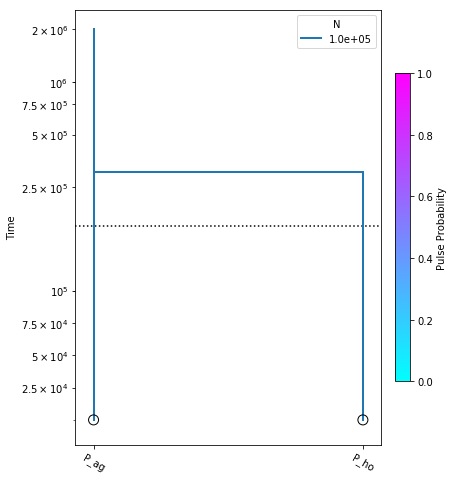

In [107]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    no_migration_model, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [112]:
#pure isolation model estimate pop sizes for P. ag and P. hom
popsizes_model = momi.DemographicModel(N_e=1e5, gen_time=1.7, muts_per_gen = 8.5e-10)

popsizes_model.set_data(sfs)
popsizes_model.add_time_param("tdiv", upper = 3e6, lower = 200000)
popsizes_model.add_size_param("n_ag")
popsizes_model.add_size_param("n_ho")

popsizes_model.add_leaf("P_ag", N="n_ag")
popsizes_model.add_leaf("P_ho", N="n_ho")
popsizes_model.move_lineages("P_ho", "P_ag", t="tdiv")

popsizes_model.stochastic_optimize(num_iters=1000,snps_per_minibatch=750)
popsizes_model.optimize()
popsizes_model.stochastic_optimize(num_iters=1000,snps_per_minibatch=1000)
popsizes_model.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


            fun: 2.5954909192435154
            jac: array([-1.64732970e-08, -1.34167972e-07,  1.12923985e-07])
  kl_divergence: 2.5954909192435154
 log_likelihood: -189.6665732175467
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 3
            nit: 1
     parameters: ParamsDict({'tdiv': 2455679.2479494824, 'n_ag': 1130529.0435206338, 'n_ho': 630846.3317745585})
         status: 1
        success: True
              x: array([ 1.42166773, 13.93819626, 13.35481758])

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/demo_plotter.py:534: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


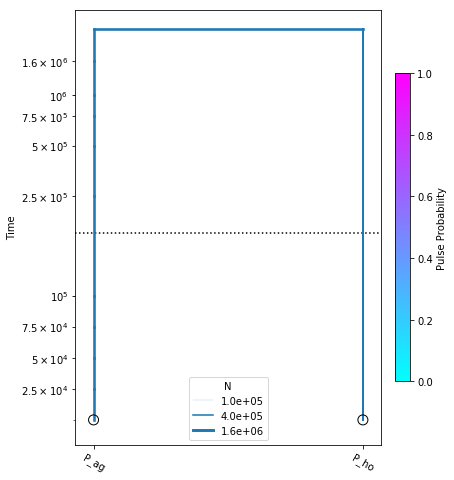

In [113]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 1.6e6]

fig = momi.DemographyPlot(
    popsizes_model, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [114]:
#assymetric migration model with single pulse from aglaiae to homochrous
#because this is coalescent, pulses are modeled "backwards"
#i.e. move_lineages from ho to ag in coalescent time is equivalent to migration from ag to ho in forward time

migration_model = momi.DemographicModel(N_e=1e5, gen_time=1, muts_per_gen = 8.5e-10)

migration_model.set_data(sfs)

migration_model.add_pulse_param("mfrac_ho_ag", upper=0.2)

migration_model.add_size_param("n_ag")
migration_model.add_size_param("n_ho")

migration_model.add_leaf("P_ag", N="n_ag")
migration_model.add_leaf("P_ho", N="n_ho")

migration_model.add_time_param("tdiv", upper = 3e6, lower = 200000)
migration_model.add_time_param("tmig_ho_ag", upper_constraints=["tdiv"])

migration_model.move_lineages("P_ho", "P_ag", t="tmig_ho_ag", p="mfrac_ho_ag")
migration_model.move_lineages("P_ho", "P_ag", t="tdiv")

migration_model.stochastic_optimize(num_iters=1000,snps_per_minibatch=750)
migration_model.optimize()
migration_model.stochastic_optimize(num_iters=1000,snps_per_minibatch=1000)
migration_model.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


            fun: 2.536432700799068
            jac: array([-4.75128537e-02,  1.51123974e-08, -1.26669290e-08,  1.92589661e-10,
        7.00988056e-09])
  kl_divergence: 2.536432700799068
 log_likelihood: -186.71366229532435
        message: 'Local minimum reached (|pg| ~= 0)'
           nfev: 3
            nit: 1
     parameters: ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1100654.6916611628, 'n_ho': 356910.17434327654, 'tdiv': 2988018.7216699496, 'tmig_ho_ag': 245144.59634326329})
         status: 0
        success: True
              x: array([-1.38629436, 13.91141573, 12.78523942,  5.44974119, -2.41491337])

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/demo_plotter.py:534: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


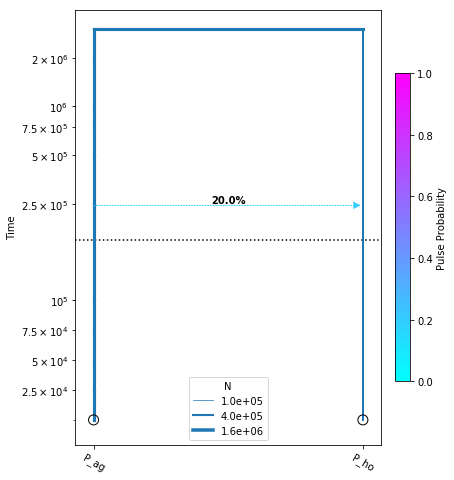

In [115]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [116]:
#assymetrical migration model 2 where pulse from hom to agl

migration_model2 = momi.DemographicModel(N_e=1e5, gen_time=1.7, muts_per_gen = 8.5e-10)

migration_model2.set_data(sfs)

migration_model2.add_pulse_param("mfrac_ag_ho", upper=0.2)

migration_model2.add_size_param("n_ag")
migration_model2.add_size_param("n_ho")

migration_model2.add_leaf("P_ag", N="n_ag")
migration_model2.add_leaf("P_ho", N="n_ho")

migration_model2.add_time_param("tdiv", upper = 3e6, lower = 200000)
migration_model2.add_time_param("tmig_ag_ho", upper_constraints=["tdiv"])

migration_model2.move_lineages("P_ag", "P_ho", t="tmig_ag_ho", p="mfrac_ag_ho")

migration_model2.move_lineages("P_ho", "P_ag", t="tdiv")

migration_model2.stochastic_optimize(num_iters=1000,snps_per_minibatch=750)
migration_model2.optimize()
migration_model2.stochastic_optimize(num_iters=1000,snps_per_minibatch=1000)
migration_model2.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


            fun: 2.595490938764155
            jac: array([ 1.95201554e-08, -8.29310194e-12,  2.28644650e-11,  5.90752235e-11,
       -1.92887378e-08])
  kl_divergence: 2.595490938764155
 log_likelihood: -189.6665741935787
        message: 'Local minimum reached (|pg| ~= 0)'
           nfev: 1
            nit: 0
     parameters: ParamsDict({'mfrac_ag_ho': 2.7664700803995108e-05, 'n_ag': 1130529.570277641, 'n_ho': 630846.8734690709, 'tdiv': 2455683.097085479, 'tmig_ag_ho': 2426032.197438838})
         status: 0
        success: True
              x: array([-10.49532563,  13.93819673,  13.35481844,   1.42167651,
         4.40451989])

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/demo_plotter.py:534: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


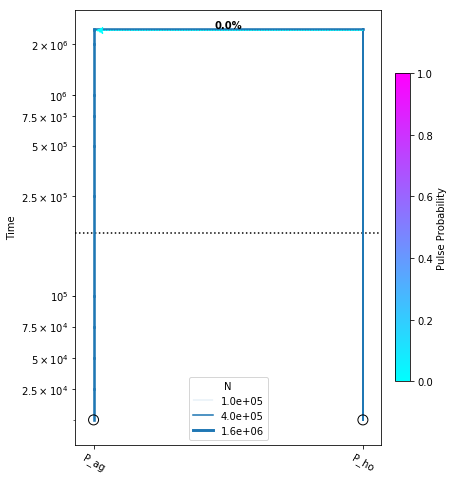

In [117]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model2, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [118]:
#ancestral migration older than LIG 125000 years
migration_model3 = momi.DemographicModel(N_e=1e5, gen_time=1.7, muts_per_gen = 8.5e-10)

migration_model3.set_data(sfs)
migration_model3.add_pulse_param("mfrac_ag_ho", upper=0.2)
migration_model3.add_pulse_param("mfrac_ho_ag", upper=0.2)

migration_model3.add_size_param("n_ag")
migration_model3.add_size_param("n_ho")

migration_model3.add_leaf("P_ag", N="n_ag")
migration_model3.add_leaf("P_ho", N="n_ho")

migration_model3.add_time_param("tdiv", upper = 3e6, lower = 200000)
migration_model3.add_time_param("tmig_ag_ho",upper_constraints=["tdiv"], lower=130000)
migration_model3.add_time_param("tmig_ho_ag",upper_constraints=["tdiv"], lower=130000)

migration_model3.move_lineages("P_ag", "P_ho", t="tmig_ag_ho", p="mfrac_ag_ho")
migration_model3.move_lineages("P_ho", "P_ag", t="tmig_ho_ag", p="mfrac_ho_ag")

migration_model3.move_lineages("P_ho", "P_ag", t="tdiv")

migration_model3.stochastic_optimize(num_iters=1000,snps_per_minibatch=750)
migration_model3.optimize()
migration_model3.stochastic_optimize(num_iters=1000,snps_per_minibatch=1000)
migration_model3.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


            fun: 2.5474624474989556
            jac: array([ 8.41769038e-11, -2.86077275e-02, -1.11754194e-07,  1.50149295e-07,
       -1.66288296e-10, -8.41337942e-11, -6.38638323e-08])
  kl_divergence: 2.5474624474989556
 log_likelihood: -187.26514963031872
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 8
            nit: 2
     parameters: ParamsDict({'mfrac_ag_ho': 4.859448186964455e-06, 'mfrac_ho_ag': 0.2, 'n_ag': 860067.3835399684, 'n_ho': 290289.1215781549, 'tdiv': 2999999.9876309903, 'tmig_ag_ho': 2999420.7435557623, 'tmig_ho_ag': 347765.00922417303})
         status: 1
        success: True
              x: array([-12.23458081,  -1.38629436,  13.66476602,  12.57863268,
        19.23769114,   8.5078968 ,  -2.49974141])

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/demo_plotter.py:534: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


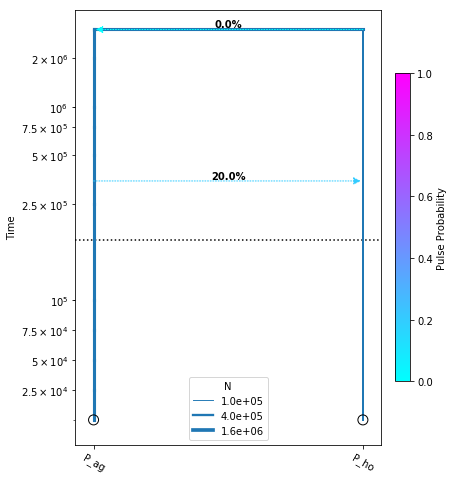

In [119]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model3, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [120]:
#secondary contact model younger than LIG 125000 yrs
migration_model4 = momi.DemographicModel(N_e=1e5, gen_time=1.7, muts_per_gen = 8.5e-10)

migration_model4.set_data(sfs)

migration_model4.add_pulse_param("mfrac_ag_ho", upper=0.2)
migration_model4.add_pulse_param("mfrac_ho_ag", upper=0.2)

migration_model4.add_size_param("n_ag")
migration_model4.add_size_param("n_ho")

migration_model4.add_leaf("P_ag", N="n_ag")
migration_model4.add_leaf("P_ho", N="n_ho")

migration_model4.add_time_param("tdiv", upper = 3e6, lower = 200000)
migration_model4.add_time_param("tmig_ag_ho", upper=130000, lower=1)
migration_model4.add_time_param("tmig_ho_ag",upper=130000, lower=1)

migration_model4.move_lineages("P_ag", "P_ho", t="tmig_ag_ho", p="mfrac_ag_ho")
migration_model4.move_lineages("P_ho", "P_ag", t="tmig_ho_ag", p="mfrac_ho_ag")

migration_model4.move_lineages("P_ho", "P_ag", t="tdiv")

migration_model4.stochastic_optimize(num_iters=1000,snps_per_minibatch=750)
migration_model4.optimize()
migration_model4.stochastic_optimize(num_iters=1000,snps_per_minibatch=1000)
migration_model4.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


            fun: 2.549710561559769
            jac: array([ 1.81421826e-08, -5.82375165e-02, -1.49179051e-09, -2.32654880e-10,
       -8.23777332e-10,  2.89551252e-10, -8.67036315e-10])
  kl_divergence: 2.549710561559769
 log_likelihood: -187.37755533335937
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 11
            nit: 3
     parameters: ParamsDict({'mfrac_ag_ho': 0.005923845870423679, 'mfrac_ho_ag': 0.2, 'n_ag': 684477.5704534154, 'n_ho': 140166.83637593035, 'tdiv': 2999999.938393419, 'tmig_ag_ho': 1.002823373861232, 'tmig_ho_ag': 129999.99577011669})
         status: 1
        success: True
              x: array([ -5.12282794,  -1.38629436,  13.43641116,  11.85058868,
        17.63211653, -17.64510472,  17.24086287])

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/demo_plotter.py:534: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


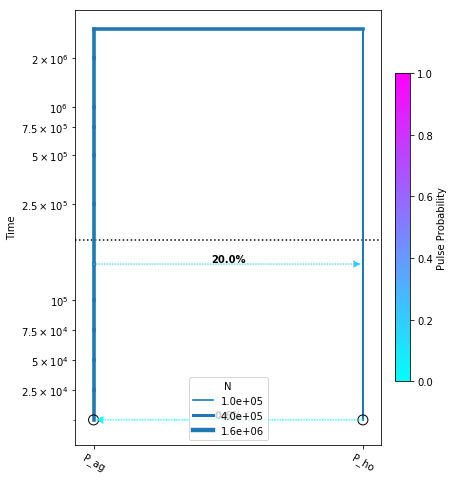

In [121]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model4, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [122]:
#continuous migration modeled as four evenly spaced bi-directional migration events at contemporary, 280, 560, 820, and 1120kya
migration_model5 = momi.DemographicModel(N_e=1e5, gen_time=1.7, muts_per_gen = 8.5e-10)

migration_model5.set_data(sfs)

migration_model5.add_pulse_param("mfrac_ag_ho", upper=0.2)
migration_model5.add_pulse_param("mfrac_ho_ag", upper=0.2)

migration_model5.add_size_param("n_ag")
migration_model5.add_size_param("n_ho")

migration_model5.add_leaf("P_ag", N="n_ag")
migration_model5.add_leaf("P_ho", N="n_ho")

migration_model5.add_time_param("tdiv", upper = 3e6, lower = 200000)
migration_model5.move_lineages("P_ag", "P_ho", t=1, p="mfrac_ag_ho")
migration_model5.move_lineages("P_ho", "P_ag", t=1, p="mfrac_ho_ag")

migration_model5.move_lineages("P_ag", "P_ho", t=lambda params: 1*(params.tdiv / 5), p="mfrac_ag_ho")
migration_model5.move_lineages("P_ho", "P_ag", t=lambda params: 1*(params.tdiv / 5), p="mfrac_ho_ag")

migration_model5.move_lineages("P_ag", "P_ho", t=lambda params: 2*(params.tdiv / 5), p="mfrac_ag_ho")
migration_model5.move_lineages("P_ho", "P_ag", t=lambda params: 2*(params.tdiv / 5), p="mfrac_ho_ag")

migration_model5.move_lineages("P_ag", "P_ho", t=lambda params: 3*(params.tdiv / 5), p="mfrac_ag_ho")
migration_model5.move_lineages("P_ho", "P_ag", t=lambda params: 3*(params.tdiv / 5), p="mfrac_ho_ag")

migration_model5.move_lineages("P_ag", "P_ho", t=lambda params: 4*(params.tdiv / 5), p="mfrac_ag_ho")
migration_model5.move_lineages("P_ho", "P_ag", t=lambda params: 4*(params.tdiv / 5), p="mfrac_ho_ag")

migration_model5.move_lineages("P_ho", "P_ag", t="tdiv")

migration_model5.stochastic_optimize(num_iters=1000,snps_per_minibatch=750)
migration_model5.optimize()
migration_model5.stochastic_optimize(num_iters=1000,snps_per_minibatch=1000)
migration_model5.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


            fun: 2.583467822822968
            jac: array([ 1.42701196e-13,  1.60805676e-13,  1.27748819e-12,  3.76422046e-13,
       -1.03264345e-10])
  kl_divergence: 2.583467822822968
 log_likelihood: -189.06541839651933
        message: 'Local minimum reached (|pg| ~= 0)'
           nfev: 1
            nit: 0
     parameters: ParamsDict({'mfrac_ag_ho': 0.004619319493959637, 'mfrac_ho_ag': 0.023054505285940656, 'n_ag': 1009892.4713747805, 'n_ho': 564954.0885234234, 'tdiv': 2999999.976493337})
         status: 0
        success: True
              x: array([-5.37287786, -3.74656965, 13.82535442, 13.24449975, 18.59560133])

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/demo_plotter.py:534: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


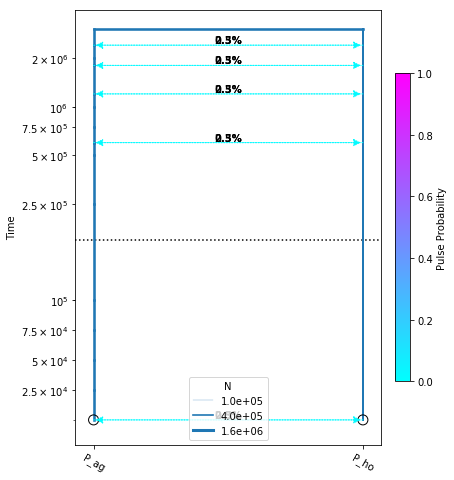

In [123]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model5, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [124]:
#repeated secondary contact model. biderctional pulse after LGM and pulse before LGM 22000 yrs ago

migration_model6 = momi.DemographicModel(N_e=1e5, gen_time=1.7, muts_per_gen = 8.5e-10)

migration_model6.set_data(sfs)

migration_model6.add_pulse_param("mfrac_ag_ho", upper=0.2)
migration_model6.add_pulse_param("mfrac_ho_ag", upper=0.2)
migration_model6.add_pulse_param("mfrac_ag_ho2", upper=0.2)
migration_model6.add_pulse_param("mfrac_ho_ag2", upper=0.2)

migration_model6.add_size_param("n_ag")
migration_model6.add_size_param("n_ho")

migration_model6.add_leaf("P_ag", N="n_ag")
migration_model6.add_leaf("P_ho", N="n_ho")

migration_model6.add_time_param("tdiv", upper=3e6, lower=200000)
migration_model6.add_time_param("tmig_ag_ho", upper_constraints=["tdiv"], lower=125000)
migration_model6.add_time_param("tmig_ho_ag",upper_constraints=["tdiv"], lower=125000)
migration_model6.add_time_param("tmig_ag_ho2", upper=125000, lower=1)
migration_model6.add_time_param("tmig_ho_ag2",upper=125000, lower=1)

migration_model6.move_lineages("P_ag", "P_ho", t="tmig_ag_ho", p="mfrac_ag_ho")
migration_model6.move_lineages("P_ho", "P_ag", t="tmig_ho_ag", p="mfrac_ho_ag")

migration_model6.move_lineages("P_ag", "P_ho", t="tmig_ag_ho2", p="mfrac_ag_ho2")
migration_model6.move_lineages("P_ho", "P_ag", t="tmig_ho_ag2", p="mfrac_ho_ag2")

migration_model6.move_lineages("P_ho", "P_ag", t="tdiv")

migration_model6.stochastic_optimize(num_iters=1000,snps_per_minibatch=750)
migration_model6.optimize()
migration_model6.stochastic_optimize(num_iters=1000,snps_per_minibatch=1000)
migration_model6.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


            fun: 2.527554941989143
            jac: array([ 4.12697046e-11, -2.22201614e-04, -1.00078433e-06, -1.42110212e-06,
        9.67692558e-09,  1.61362221e-07, -1.38078097e-17, -4.12158331e-11,
       -1.79139321e-06,  7.96428516e-11, -4.99578599e-11])
  kl_divergence: 2.527554941989143
 log_likelihood: -186.26977435482806
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 13
            nit: 4
     parameters: ParamsDict({'mfrac_ag_ho': 3.8364855121216773e-07, 'mfrac_ho_ag': 0.2, 'mfrac_ag_ho2': 0.005506931716479942, 'mfrac_ho_ag2': 0.17411558729226767, 'n_ag': 628520.8291101654, 'n_ho': 82999.35908441986, 'tdiv': 2999999.9999999995, 'tmig_ag_ho': 2999314.866085171, 'tmig_ho_ag': 136608.9152259085, 'tmig_ag_ho2': 1.0007654278734355, 'tmig_ho_ag2': 124999.99885566402})
         status: 1
        success: True
              x: array([-14.77353855,  -1.38629436,  -5.19622552,  -1.55673545,
        13.35112445,  11.32658816,  36.05395713,   8.34171058,
        -5.5

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/demo_plotter.py:534: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


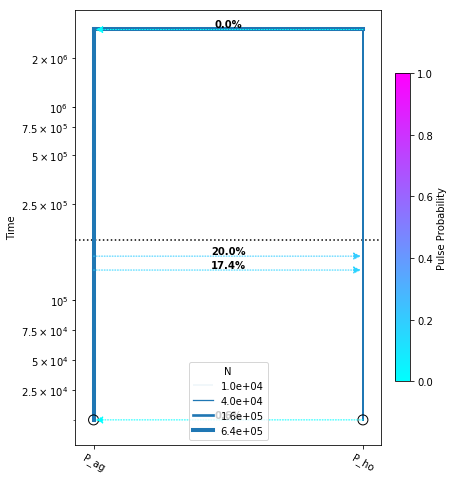

In [125]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model6, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [126]:
import numpy as np

AICs = []
for model in [popsizes_model, migration_model, migration_model2, migration_model3, migration_model4,migration_model5,migration_model6]:
    lik = model.log_likelihood()
    nparams = len(model.get_params())
    aic = 2*nparams - 2*lik
    print("AIC {}".format(aic))
    AICs.append(aic)

minv = np.min(AICs)
delta_aic = np.array(AICs) - minv
print("Delta AIC per model: ", delta_aic)
print("AIC weight per model: ", np.exp(-0.5 * delta_aic))


AIC 385.3331464350934
AIC 383.4273245906487
AIC 389.3331483871574
AIC 388.53029926063743
AIC 388.75511066671874
AIC 388.13083679303867
AIC 394.5395487096561
Delta AIC per model:  [ 1.90582184  0.          5.9058238   5.10297467  5.32778608  4.7035122
 11.11222412]
AIC weight per model:  [0.38561689 1.         0.05218752 0.07796562 0.06967644 0.09520183
 0.00386377]


In [127]:
#bootstrapping the best model for parameter estimates with variance

n_bootstraps = 1000
# make copies of the original model to avoid changing them
migration_model_copy = migration_model.copy()

bootstrap_results = []
for i in range(n_bootstraps):
    print(f"Fitting {i+1}th bootstrap out of {n_bootstraps}")

    # resample the data
    resampled_sfs = sfs.resample()
    # tell models to use the new dataset
    migration_model_copy.set_data(resampled_sfs)

    # choose new random parameters for submodel, optimize
    migration_model_copy.set_params(randomize=True)
    migration_model_copy.optimize(method="L-BFGS-B")
    migration_model_copy.optimize()

    bootstrap_results.append(migration_model_copy.get_params())
    
    print(migration_model_copy.get_params())
    
print("END")

Fitting 1th bootstrap out of 1000


/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1020852.6093907215, 'n_ho': 287392.62861395965, 'tdiv': 2999992.010026636, 'tmig_ho_ag': 207948.71795219096})
Fitting 2th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1114233.7016922971, 'n_ho': 5.364730508858679, 'tdiv': 2999981.641518556, 'tmig_ho_ag': 3.4518097915415304})
Fitting 3th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 797170.9566790827, 'n_ho': 461930.1679014089, 'tdiv': 2999999.084506055, 'tmig_ho_ag': 438396.39374598})
Fitting 4th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1165480.5192165955, 'n_ho': 126372.67350163127, 'tdiv': 2877564.2655808586, 'tmig_ho_ag': 62642.22966995847})
Fitting 5th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1078153.8363741483, 'n_ho': 225515.47022475657, 'tdiv': 2999994.698988091, 'tmig_ho_ag': 161359.50962160827})
Fitting 6th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 865863.6069831632, 'n_ho': 620624.5496435711, 

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1119149.6110527792, 'n_ho': 536612.2846378426, 'tdiv': 2677327.1940044235, 'tmig_ho_ag': 357007.5204998635})
Fitting 47th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 779168.6156198063, 'n_ho': 194227.40733839685, 'tdiv': 2999999.1720901323, 'tmig_ho_ag': 71745.4123589385})
Fitting 48th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.0005194072813076901, 'n_ag': 1503700.0630470533, 'n_ho': 480975.4518111028, 'tdiv': 1052585.218144692, 'tmig_ho_ag': 1052578.249923767})
Fitting 49th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 803101.6659009511, 'n_ho': 402308.1039925704, 'tdiv': 2999808.1466583298, 'tmig_ho_ag': 277320.0539187761})
Fitting 50th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 4.11403824135656e-06, 'n_ag': 929943.5360723169, 'n_ho': 835938.8845892556, 'tdiv': 1860325.7979576567, 'tmig_ho_ag': 1858894.1657745857})
Fitting 51th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1192590.

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in double_scalars
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 938331.3856681795, 'n_ho': 511341.351123737, 'tdiv': 2999988.67244441, 'tmig_ho_ag': 484156.90320112766})
Fitting 84th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1084787.031634807, 'n_ho': 340664.4389544914, 'tdiv': 989803.5958591311, 'tmig_ho_ag': 272350.90535161295})
Fitting 85th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1077544.2550786936, 'n_ho': 291623.8116723413, 'tdiv': 2999994.6448148983, 'tmig_ho_ag': 250189.81233002123})
Fitting 86th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1290046.5404772449, 'n_ho': 376586.4469271242, 'tdiv': 2103826.200723121, 'tmig_ho_ag': 233779.68093507236})
Fitting 87th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1118320.905123482, 'n_ho': 668720.001388351, 'tdiv': 2033440.6619837491, 'tmig_ho_ag': 661636.0519745905})
Fitting 88th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1028087.308830971, 'n_ho': 35877.98613648474,

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1076221.4621401087, 'n_ho': 381033.96664351335, 'tdiv': 1397240.3613247112, 'tmig_ho_ag': 348641.6557827148})
Fitting 129th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 1.1946257236382823e-11, 'n_ag': 778050.2509404724, 'n_ho': 733094.5084077305, 'tdiv': 1995256.269815844, 'tmig_ho_ag': 1995244.1036110315})
Fitting 130th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 870338.9142065945, 'n_ho': 1.5490812576234925, 'tdiv': 2999993.356168515, 'tmig_ho_ag': 0.7046726628375795})
Fitting 131th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 856373.4785484383, 'n_ho': 532472.1543317544, 'tdiv': 2313483.918548718, 'tmig_ho_ag': 489043.269488463})
Fitting 132th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 792358.6643945938, 'n_ho': 322646.0674770991, 'tdiv': 2999930.1653769864, 'tmig_ho_ag': 195880.00925030795})
Fitting 133th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 675070.30991819, 'n

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1003584.912255482, 'n_ho': 173821.62482008163, 'tdiv': 2999999.3662343384, 'tmig_ho_ag': 94909.09075978668})
Fitting 173th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1144449.4766827615, 'n_ho': 186556.8418546053, 'tdiv': 2999999.1089604273, 'tmig_ho_ag': 160142.3046640321})
Fitting 174th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 6.679064445686735e-44, 'n_ag': 1135561.182988637, 'n_ho': 581916.2478398476, 'tdiv': 1511550.704344574, 'tmig_ho_ag': 1511550.704344574})
Fitting 175th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 715968.6279366371, 'n_ho': 14841.480246374422, 'tdiv': 2999926.330383861, 'tmig_ho_ag': 7568.065772906582})
Fitting 176th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1207993.589839308, 'n_ho': 453543.9045186834, 'tdiv': 2278796.9435224794, 'tmig_ho_ag': 597215.5813339122})
Fitting 177th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.00028334158251695725, 'n_ag': 12

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 958308.4237414725, 'n_ho': 539951.0362982401, 'tdiv': 2860827.77158896, 'tmig_ho_ag': 264519.50870241434})
Fitting 217th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1152588.5526443496, 'n_ho': 581861.1060474479, 'tdiv': 2983311.780911517, 'tmig_ho_ag': 308233.3683244973})
Fitting 218th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1161781.2042635435, 'n_ho': 245541.05121720862, 'tdiv': 1814158.2136467714, 'tmig_ho_ag': 120457.29456780547})
Fitting 219th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1454855.3004997175, 'n_ho': 44902.87982043102, 'tdiv': 2384525.551169779, 'tmig_ho_ag': 40017.26718443019})
Fitting 220th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 775344.9763478164, 'n_ho': 371284.41351705324, 'tdiv': 2999982.489294368, 'tmig_ho_ag': 185381.59944017045})
Fitting 221th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1106808.7579580068, 'n_ho': 194387.67

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1108103.4909033156, 'n_ho': 376014.3884029975, 'tdiv': 2092963.692085684, 'tmig_ho_ag': 291240.9662411049})
Fitting 262th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1147702.347953435, 'n_ho': 72456.35435284331, 'tdiv': 2899785.6205087667, 'tmig_ho_ag': 63760.186241805255})
Fitting 263th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1013858.4803528822, 'n_ho': 460723.15569005633, 'tdiv': 2999996.53199152, 'tmig_ho_ag': 473709.31076108885})
Fitting 264th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 2.4348601135291306e-08, 'n_ag': 1344611.027713601, 'n_ho': 1344475.19767429, 'tdiv': 2999999.9994776375, 'tmig_ho_ag': 2999999.9994776375})
Fitting 265th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 4.237860808055325e-09, 'n_ag': 849354.9772537393, 'n_ho': 695322.2478773698, 'tdiv': 1619784.486648821, 'tmig_ho_ag': 1619582.3356689839})
Fitting 266th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 9

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:73: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)


ParamsDict({'mfrac_ho_ag': 3.8989280613825116e-09, 'n_ag': 1085324.1420873736, 'n_ho': 823990.2121014418, 'tdiv': 1867801.1096556967, 'tmig_ho_ag': 846.775070698319})
Fitting 269th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1079038.2752569267, 'n_ho': 535724.7306182038, 'tdiv': 2051208.0409524764, 'tmig_ho_ag': 708616.6489707229})
Fitting 270th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1270757.701416266, 'n_ho': 26812.51556122042, 'tdiv': 2951167.858289809, 'tmig_ho_ag': 22076.773950455638})
Fitting 271th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1123738.3575500082, 'n_ho': 92090.9936519615, 'tdiv': 2999867.9093906074, 'tmig_ho_ag': 59692.72727535365})
Fitting 272th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1598011.69565427, 'n_ho': 183579.7187456637, 'tdiv': 743358.3446438668, 'tmig_ho_ag': 219006.1230430263})
Fitting 273th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1102150.8871595324, 'n

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1055953.771287211, 'n_ho': 406956.24275632674, 'tdiv': 2999993.2582878694, 'tmig_ho_ag': 370247.636059691})
Fitting 313th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 568221.8537301671, 'n_ho': 303146.73446272063, 'tdiv': 2999999.487670205, 'tmig_ho_ag': 161213.39420419442})
Fitting 314th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1212115.227108702, 'n_ho': 396386.0584736419, 'tdiv': 1190319.3848182592, 'tmig_ho_ag': 381394.46859281213})
Fitting 315th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 967442.4322607715, 'n_ho': 597211.2607233066, 'tdiv': 2999872.65996724, 'tmig_ho_ag': 387724.70677110105})
Fitting 316th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 812763.0744790662, 'n_ho': 200677.42550983484, 'tdiv': 2999994.721098475, 'tmig_ho_ag': 83284.35561937907})
Fitting 317th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 999884.5871717723, 'n_ho': 259451.15250

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1083240.397117654, 'n_ho': 319418.3464343963, 'tdiv': 2890083.9023980577, 'tmig_ho_ag': 224385.42982484595})
Fitting 357th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 593757.9913728324, 'n_ho': 209791.7078587839, 'tdiv': 2999998.0643688715, 'tmig_ho_ag': 79884.64053379578})
Fitting 358th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 1.722051066208195e-07, 'n_ag': 1322340.8415261975, 'n_ho': 753180.0238627603, 'tdiv': 1457336.5751665893, 'tmig_ho_ag': 37387.452480695814})
Fitting 359th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 724516.6294388943, 'n_ho': 206265.94487111404, 'tdiv': 2999984.2540984806, 'tmig_ho_ag': 102619.53273638751})
Fitting 360th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 843509.9284438475, 'n_ho': 52785.40715235957, 'tdiv': 2999962.1931698797, 'tmig_ho_ag': 22863.23558708185})
Fitting 361th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1449272.196084557

ParamsDict({'mfrac_ho_ag': 1.5439703398710242e-05, 'n_ag': 880812.5545168563, 'n_ho': 718729.502276149, 'tdiv': 2131465.2422431204, 'tmig_ho_ag': 2131465.2422431204})
Fitting 401th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1316645.0230907302, 'n_ho': 345754.19476972683, 'tdiv': 1789535.092979529, 'tmig_ho_ag': 228646.4064630543})
Fitting 402th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 882967.7582374812, 'n_ho': 1.0234805814556458, 'tdiv': 2999997.617517639, 'tmig_ho_ag': 0.4140536375226253})
Fitting 403th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 912925.762958722, 'n_ho': 348087.01839390484, 'tdiv': 2999996.6243298063, 'tmig_ho_ag': 291923.9675416341})
Fitting 404th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1243108.2354962938, 'n_ho': 67358.38858285552, 'tdiv': 2155973.9350077333, 'tmig_ho_ag': 46654.343517370915})
Fitting 405th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1072836.363676036

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 921558.8793909358, 'n_ho': 55583.94660214539, 'tdiv': 2999999.2298497367, 'tmig_ho_ag': 29516.691903916584})
Fitting 446th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1176437.8700916178, 'n_ho': 615665.5306336525, 'tdiv': 2125100.3399104266, 'tmig_ho_ag': 603123.5120168342})
Fitting 447th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 928970.4681694495, 'n_ho': 242787.40225975204, 'tdiv': 2999941.1972431466, 'tmig_ho_ag': 187861.99514377926})
Fitting 448th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.0003360967397701865, 'n_ag': 1044539.4473714757, 'n_ho': 746462.7252101367, 'tdiv': 1897756.8090885328, 'tmig_ho_ag': 713744.1481096027})
Fitting 449th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1008518.503823579, 'n_ho': 97690.300050093, 'tdiv': 2647322.7764095613, 'tmig_ho_ag': 78743.39602652797})
Fitting 450th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 861458.7035370865, 

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1317291.7485785345, 'n_ho': 287040.02287599165, 'tdiv': 1474322.9483196626, 'tmig_ho_ag': 347366.62553519435})
Fitting 491th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 906917.8634040125, 'n_ho': 159078.44249968836, 'tdiv': 2999999.2983900164, 'tmig_ho_ag': 115383.75918132102})
Fitting 492th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 886181.1588323204, 'n_ho': 667282.9171764842, 'tdiv': 2999986.3363678674, 'tmig_ho_ag': 384378.22023885796})
Fitting 493th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 993144.031290563, 'n_ho': 410785.5965139139, 'tdiv': 2999996.3959159553, 'tmig_ho_ag': 270327.06200466986})
Fitting 494th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1050607.2998684181, 'n_ho': 173159.47893508204, 'tdiv': 2999881.521204173, 'tmig_ho_ag': 165157.43141553365})
Fitting 495th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.0005152838779647617, 'n_ag': 1063885.502643

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 884431.149735713, 'n_ho': 225824.01319358475, 'tdiv': 2999995.1800901024, 'tmig_ho_ag': 195680.20183042675})
Fitting 535th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1067036.3502057162, 'n_ho': 398309.2146912489, 'tdiv': 2789749.1493628495, 'tmig_ho_ag': 231369.65755245634})
Fitting 536th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1062865.3665878607, 'n_ho': 693404.7098333917, 'tdiv': 2999958.056905515, 'tmig_ho_ag': 749491.8060833436})
Fitting 537th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 829623.2370121315, 'n_ho': 111524.0190497093, 'tdiv': 2999992.635089474, 'tmig_ho_ag': 61014.76124036615})
Fitting 538th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 966572.636974294, 'n_ho': 188034.85339827984, 'tdiv': 2999998.63011061, 'tmig_ho_ag': 96602.16181883172})
Fitting 539th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1201134.557245144, 'n_ho': 340141.322282

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1139927.2954455009, 'n_ho': 281931.5767880811, 'tdiv': 2626908.9880272606, 'tmig_ho_ag': 215616.332489238})
Fitting 580th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1118818.4018010425, 'n_ho': 290453.64481595764, 'tdiv': 1618560.6042577769, 'tmig_ho_ag': 341698.9866628077})
Fitting 581th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1373307.1455310788, 'n_ho': 45834.51869992075, 'tdiv': 2303892.9522099937, 'tmig_ho_ag': 20212.6667512903})
Fitting 582th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1238255.0545259386, 'n_ho': 222599.64151623566, 'tdiv': 2606965.468729005, 'tmig_ho_ag': 152560.69150319308})
Fitting 583th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 833049.8311469632, 'n_ho': 173657.05966169716, 'tdiv': 2999991.686509475, 'tmig_ho_ag': 91370.59579070848})
Fitting 584th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 820348.7007421786, 'n_ho': 315991.28

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 755117.3985858661, 'n_ho': 294902.317930458, 'tdiv': 2999998.549826439, 'tmig_ho_ag': 222037.9705033441})
Fitting 625th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1024763.7089335853, 'n_ho': 503525.01800750307, 'tdiv': 1988666.4919356713, 'tmig_ho_ag': 504617.6292365576})
Fitting 626th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1105823.1592592725, 'n_ho': 384891.25396390265, 'tdiv': 2430498.777819329, 'tmig_ho_ag': 234360.5098055711})
Fitting 627th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 864854.877025719, 'n_ho': 869649.4091044792, 'tdiv': 2999961.417410362, 'tmig_ho_ag': 592241.1675231197})
Fitting 628th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1138928.9317835884, 'n_ho': 394490.96657723543, 'tdiv': 2999976.5013291743, 'tmig_ho_ag': 345189.944426919})
Fitting 629th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 992845.1058854037, 'n_ho': 579568.831761

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 716968.3189563702, 'n_ho': 321196.7799909949, 'tdiv': 2999984.0712634744, 'tmig_ho_ag': 146358.04385098105})
Fitting 669th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1063744.766470035, 'n_ho': 621232.4893681465, 'tdiv': 2248140.96992101, 'tmig_ho_ag': 364017.49769898824})
Fitting 670th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.19926574001204164, 'n_ag': 1022742.8729807455, 'n_ho': 1.0, 'tdiv': 2999962.066476691, 'tmig_ho_ag': 0.5469410743600706})
Fitting 671th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 935920.2286394066, 'n_ho': 360993.25104257494, 'tdiv': 2999989.717192522, 'tmig_ho_ag': 266244.459612992})
Fitting 672th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1280912.4078178387, 'n_ho': 83685.49706857355, 'tdiv': 1894793.8172737905, 'tmig_ho_ag': 58582.494941581404})
Fitting 673th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 837203.8767578753, 'n_ho': 331904.06

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1399004.9392044905, 'n_ho': 393676.1460541668, 'tdiv': 2129052.521160027, 'tmig_ho_ag': 845721.1374613054})
Fitting 713th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.17054602034933683, 'n_ag': 1145465.8133378243, 'n_ho': 116819.29747976606, 'tdiv': 2999996.448212218, 'tmig_ho_ag': 104802.85944627754})
Fitting 714th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1313345.3789768142, 'n_ho': 201846.7722164085, 'tdiv': 2068632.1429570778, 'tmig_ho_ag': 238803.1542521449})
Fitting 715th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 1.4308925255083678e-07, 'n_ag': 978511.5929112328, 'n_ho': 696306.7812522555, 'tdiv': 1591976.6794348136, 'tmig_ho_ag': 42332.59394056195})
Fitting 716th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1363639.424646062, 'n_ho': 351063.292061356, 'tdiv': 994272.6570063347, 'tmig_ho_ag': 622007.3484593673})
Fitting 717th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 9346

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 856134.2725113231, 'n_ho': 789555.8284372063, 'tdiv': 2199785.0205509756, 'tmig_ho_ag': 335710.04650629585})
Fitting 757th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 875789.6890486567, 'n_ho': 522001.9311743595, 'tdiv': 2999997.4798915363, 'tmig_ho_ag': 230358.5812825568})
Fitting 758th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 912577.7935193517, 'n_ho': 484047.8230837313, 'tdiv': 2999997.1400324837, 'tmig_ho_ag': 457943.92375306174})
Fitting 759th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 890471.235829056, 'n_ho': 517914.87294187467, 'tdiv': 2999915.5927842744, 'tmig_ho_ag': 272515.4706962132})
Fitting 760th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1217112.288943641, 'n_ho': 410140.8589550456, 'tdiv': 1708604.4982303712, 'tmig_ho_ag': 240371.06841004436})
Fitting 761th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1041481.8280435861, 'n_ho': 517824.78

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 948399.0740707176, 'n_ho': 157588.68503403512, 'tdiv': 2682738.987807043, 'tmig_ho_ag': 94395.47812423295})
Fitting 802th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1193293.4419749079, 'n_ho': 365494.1765911728, 'tdiv': 1890226.362877794, 'tmig_ho_ag': 354830.663059745})
Fitting 803th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 799580.7072305162, 'n_ho': 239065.06973373535, 'tdiv': 2999995.000849457, 'tmig_ho_ag': 132626.57362167223})
Fitting 804th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.0010004034584673264, 'n_ag': 954780.7135131549, 'n_ho': 918834.1217860588, 'tdiv': 1374228.409588116, 'tmig_ho_ag': 913037.9445718939})
Fitting 805th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 975484.3583935697, 'n_ho': 364745.6044052054, 'tdiv': 2999940.0101610906, 'tmig_ho_ag': 150747.41168059062})
Fitting 806th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1321048.0730178184, 'n

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 633912.1121132713, 'n_ho': 220931.1048662789, 'tdiv': 2999967.366546555, 'tmig_ho_ag': 88679.94639456125})
Fitting 846th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1239677.6192790018, 'n_ho': 338078.1520999744, 'tdiv': 763259.2629766292, 'tmig_ho_ag': 266711.65299160866})
Fitting 847th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1170357.2905498238, 'n_ho': 242252.62351928785, 'tdiv': 2999981.0515793567, 'tmig_ho_ag': 176621.59594569178})
Fitting 848th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 934800.7633641083, 'n_ho': 410101.94876122347, 'tdiv': 2999990.646174327, 'tmig_ho_ag': 310951.2780894551})
Fitting 849th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1026407.2140776695, 'n_ho': 339784.68413225206, 'tdiv': 2999992.73481222, 'tmig_ho_ag': 274540.74319349404})
Fitting 850th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 857037.2967573302, 'n_ho': 642815.99

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1088631.4953265013, 'n_ho': 143176.5197301815, 'tdiv': 2858383.0998436357, 'tmig_ho_ag': 85212.75655667178})
Fitting 890th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 997051.6450353668, 'n_ho': 255667.59852418595, 'tdiv': 2999963.863328054, 'tmig_ho_ag': 159883.1855853072})
Fitting 891th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 953944.454713813, 'n_ho': 178752.47538014955, 'tdiv': 2999998.31537509, 'tmig_ho_ag': 119560.26585704576})
Fitting 892th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1195712.8998804197, 'n_ho': 353157.75104097294, 'tdiv': 2961520.162352916, 'tmig_ho_ag': 342487.62171783735})
Fitting 893th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 996474.2927352109, 'n_ho': 438112.85866581305, 'tdiv': 2999994.1290365686, 'tmig_ho_ag': 303179.1008024896})
Fitting 894th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.198617284139435, 'n_ag': 1010370.9762195235, 'n_

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1086337.125121326, 'n_ho': 177652.36618542045, 'tdiv': 2999973.3592023714, 'tmig_ho_ag': 127970.3430363423})
Fitting 934th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1029067.3014409199, 'n_ho': 304921.5552863032, 'tdiv': 2999999.137328447, 'tmig_ho_ag': 237455.96504419402})
Fitting 935th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 725101.2461049185, 'n_ho': 467144.0752676677, 'tdiv': 2999989.037091512, 'tmig_ho_ag': 474217.0574980868})
Fitting 936th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 835758.1969934189, 'n_ho': 284089.5493429635, 'tdiv': 2999981.361544593, 'tmig_ho_ag': 165627.54748120642})
Fitting 937th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 3.0686416202266696e-18, 'n_ag': 1597829.6808399116, 'n_ho': 1411002.3312330656, 'tdiv': 2999994.7694500056, 'tmig_ho_ag': 2999994.7165223975})
Fitting 938th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1201450.925836152

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1326488.1407674546, 'n_ho': 124348.58248980757, 'tdiv': 2999994.104600499, 'tmig_ho_ag': 56463.34108768375})
Fitting 979th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 705941.3020675449, 'n_ho': 585117.5690135219, 'tdiv': 2999998.18259452, 'tmig_ho_ag': 429002.73995938903})
Fitting 980th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 790636.4554279231, 'n_ho': 737148.0732562813, 'tdiv': 2840338.074137295, 'tmig_ho_ag': 540683.2909821953})
Fitting 981th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 1320237.003327091, 'n_ho': 197262.70876575715, 'tdiv': 2860133.533889315, 'tmig_ho_ag': 119637.94789503788})
Fitting 982th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 862757.7358230785, 'n_ho': 30335.188531698237, 'tdiv': 2998994.9051069133, 'tmig_ho_ag': 20705.79143425372})
Fitting 983th bootstrap out of 1000
ParamsDict({'mfrac_ho_ag': 0.0012554855286123698, 'n_ag': 1028670.3015466427, '

In [128]:
print(migration_model_copy.get_params())

ParamsDict({'mfrac_ho_ag': 0.2, 'n_ag': 870054.7369459422, 'n_ho': 333040.66370637296, 'tdiv': 2999964.747363838, 'tmig_ho_ag': 185367.95360516576})


/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/demo_plotter.py:534: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/demo_model.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.log(x/(1.-x))


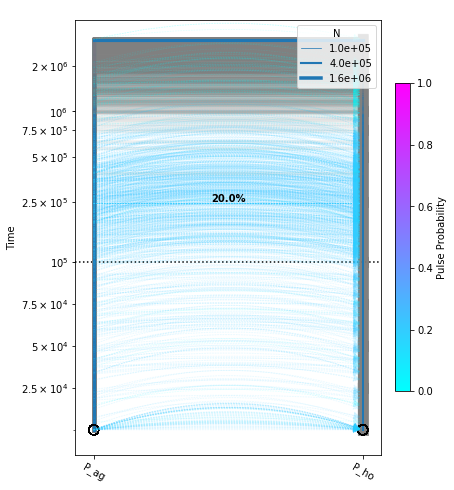

In [129]:
#plotting bs results
fig = momi.DemographyPlot(
    migration_model, ["P_ag", "P_ho"],
    linthreshy=1e5, figsize=(6,8),
    major_yticks=yticks,
    draw=False)# plot bootstraps onto the canvas in transparency
for params in bootstrap_results:
    fig.add_bootstrap(
        params,
        # alpha=0: totally transparent. alpha=1: totally opaque
        alpha=1/10)

# now draw the inferred demography on top of the bootstraps
fig.draw()
fig.draw_N_legend(loc="upper right")